In [ ]:
import os
import sys
os.chdir('..')

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Nadam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as sk_confusion_matrix



In [4]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv', index_col=0)

labels = dataset['Rating'].values - 1

In [ ]:
dataset.head()

,Review,Rating,cleaned_text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay go seahawk game awesome ...


## ***Some function that will be useful for the project***

In [5]:
def evaluate_model(model, val_sequences, val_labels):
    # Model evaluation
    val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)
    print("Validation Loss:", val_loss)
    print("Validation Accuracy:", val_accuracy)

    # Get predictions
    predictions = model.predict(val_sequences)
    predicted_labels = [np.argmax(prediction) for prediction in predictions]

    # Classification report
    print(classification_report(val_labels, predicted_labels))

In [6]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 4))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrix(model, val_sequences, val_labels):
    
    # Obtenir les prédictions
    predictions = model.predict(val_sequences)
    predicted_labels = np.argmax(predictions, axis=1)

    # Matrice de confusion
    cm = sk_confusion_matrix(val_labels, predicted_labels)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title('Matrice de confusion')
    plt.show()


# ***Neural Network Configuration and Tokenization***

In [8]:
tf.random.set_seed(21)

In [9]:
# Define hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 64

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(dataset['cleaned_text'])
sequences = tokenizer.texts_to_sequences(dataset['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')


## Hyperparameters

To configure our neural network and prepare the text data for processing, we have defined the following hyperparameters:

- **MAX_VOCAB_SIZE:** This parameter sets the maximum size of the vocabulary, controlling the number of unique words considered during tokenization. A vocabulary size of 10,000 was chosen. It is an approximation based on the Topic Modelling & ML part where we decided to remove rare and common words. After doing this we had approximately 13000 unique words so I choose to approximate this to 10000.

- **MAX_SEQUENCE_LENGTH:** This parameter defines the maximum length of input sequences. Sequences longer than this length will be truncated, while shorter sequences will be padded. A sequence length of 100 was chosen based on task requirements and typical text length. If we remember the EDA part 100 was the mean number of words in a review but as we divided by 8 the number of unique words, review will be shorter so 100 words should be sufficiant

- **EMBEDDING_DIM:** This parameter specifies the dimensionality of the word embeddings. A dimension of 64 was chosen as it is a common choice for word embedding dimensionality.

# ***Baseline Model***

## Model Explanation

1. **Embedding Layer:**
   - I used an embedding layer to represent words as continuous vectors, capturing semantic relationships between words.   

2. **First LSTM Layer (64, return_sequences=True):**
   - I chose an LSTM layer with 64 units and `return_sequences=True` to be able to detect complex pattern and to take in account the importance of the order of the words in the review.

3. **Dropout Layer (0.2):**
   - I added a Dropout layer after the first LSTM with a rate of 0.2 to regularize the model and prevent overfitting by randomly deactivating 20% of neurons during training.

4. **Second LSTM Layer (32):**
   - I used a second LSTM layer with 32 units to reduce the dimensionality of the sequential representation, potentially extracting more abstract features. LSTMs are chosen due to their ability to handle long-term dependencies in sequences, what is important in our case.

5. **Dense Layer with Softmax (5 classes):**
   - Finally, I added a dense layer with a softmax activation function and 5 units in output for multi-class classification as we have 5 class in our dataset. Softmax is used to obtain normalized probabilities for each class enabling clear interpretation and consistent handling of ratings between 1 and 5.





In [ ]:
baseline_model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
baseline_model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
baseline_history = baseline_model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=5, batch_size=32)

In [71]:
evaluate_model(baseline_model, val_sequences, val_labels)


129/129 [==============================] - 6s 43ms/step - loss: 1.2165 - accuracy: 0.4621
Validation Loss: 1.216468095779419
Validation Accuracy: 0.46206390857696533
129/129 [==============================] - 4s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.33      0.00      0.01       333
           2       0.00      0.00      0.00       432
           3       0.30      0.52      0.38      1252
           4       0.63      0.70      0.66      1790

    accuracy                           0.46      4099
   macro avg       0.25      0.24      0.21      4099
weighted avg       0.40      0.46      0.41      4099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


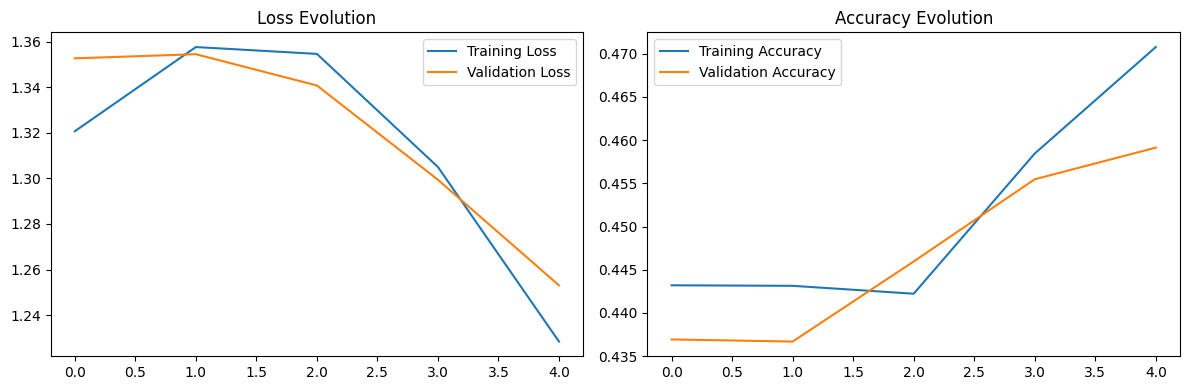

In [61]:
plot_loss_accuracy(baseline_history)

### ***Observation:***

Initial Model Evaluation:
Class Prediction Limitations:
The initial model demonstrates a significant limitation in its ability to accurately classify the categories '1' and '2'. Predominantly, it tends to predict most inputs as belonging to the most frequent class observed in the training data.

Analysis of Learning Curves:
Upon examining the learning curves, the results are moderately encouraging,  The curves for both training and validation exhibit a parallel progression, indicating a consistent learning pattern. This alignment suggests that the model is benefiting from the training process so we should train it more

# ***Enhancements: Epochs, Checkpoints, Early Stopping, and LR Adjustments***

- **Increasing Epochs:** We're increasing the number of epochs as the model showed signs of improvement, providing more opportunities for learning.

- **Implementing Checkpoints:** To protect against overfitting with increased epochs, we're using checkpoints. This lets us save the best model version before potential overfitting in later epochs.

- **Early Stopping:** This is introduced to conserve resources and prevent the model from overfitting. It stops training when the model ceases to improve.

- **Learning Rate Adjustments:** We'll tweak the learning rate (LR) to optimize the training process, ensuring efficient and effective learning.

In [12]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_cb = ReduceLROnPlateau(monitor="loss", patience=10)

In [ ]:
baseline_model2 = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

baseline_model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
baseline_2_history = baseline_model2.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])

baseline_best_model2 = load_model('model.h5')

In [73]:
evaluate_model(baseline_best_model2, val_sequences, val_labels)

129/129 [==============================] - 6s 36ms/step - loss: 0.9369 - accuracy: 0.6067
Validation Loss: 0.9369270205497742
Validation Accuracy: 0.6067333221435547
129/129 [==============================] - 5s 30ms/step
              precision    recall  f1-score   support

           0       0.66      0.37      0.47       292
           1       0.34      0.27      0.30       333
           2       0.33      0.28      0.30       432
           3       0.52      0.60      0.56      1252
           4       0.76      0.79      0.78      1790

    accuracy                           0.61      4099
   macro avg       0.52      0.46      0.48      4099
weighted avg       0.60      0.61      0.60      4099



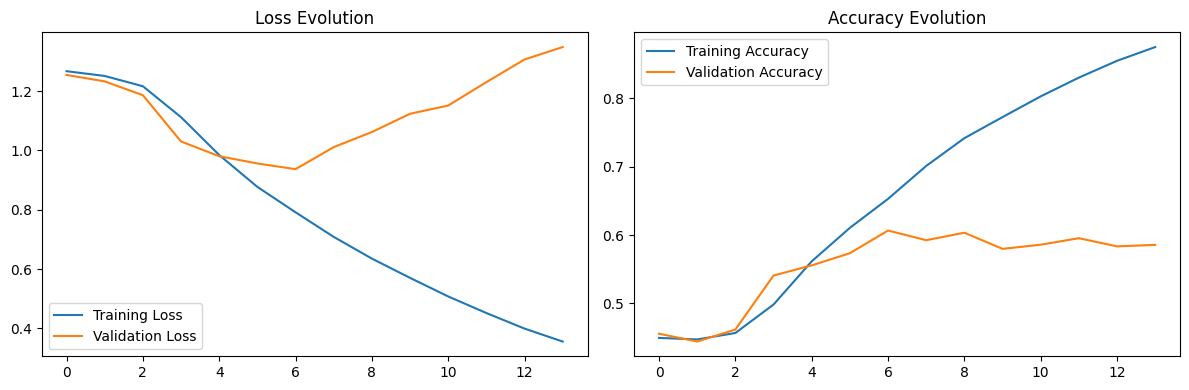

In [74]:
plot_loss_accuracy(baseline_2_history)

### ***Observation:***

This model is a huge improvement comparated to the previous one.

We already succeded to get an accuracy of 0.61 as in ML but we are still facing the same problems with the class 2 and 3. Actually we do not have as good result for f1 score as our recall is low for these classes.
By looking at the curves we notice overfitting increasing over epochs while the validation curves start to stabilize. Train more this model without modification seems to be useless

# ***Implementing class weights***

As we know that our dataset is imbalanced, we will try to implement class weights to get better results on class that has less data.

In [10]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
checkpoint = ModelCheckpoint('weighted_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)


weighted_baseline_model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

weighted_baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

weighted_baseline_history = weighted_baseline_model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=14, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

weighted_baseline_best_model2 = load_model('weighted_model.h5')



In [83]:
evaluate_model(weighted_baseline_best_model2, val_sequences, val_labels)


129/129 [==============================] - 5s 29ms/step - loss: 1.1666 - accuracy: 0.5650
Validation Loss: 1.1666234731674194
Validation Accuracy: 0.5650158524513245
129/129 [==============================] - 5s 32ms/step
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       292
           1       0.33      0.35      0.34       333
           2       0.28      0.36      0.32       432
           3       0.49      0.52      0.51      1252
           4       0.77      0.68      0.72      1790

    accuracy                           0.57      4099
   macro avg       0.50      0.50      0.50      4099
weighted avg       0.59      0.57      0.57      4099



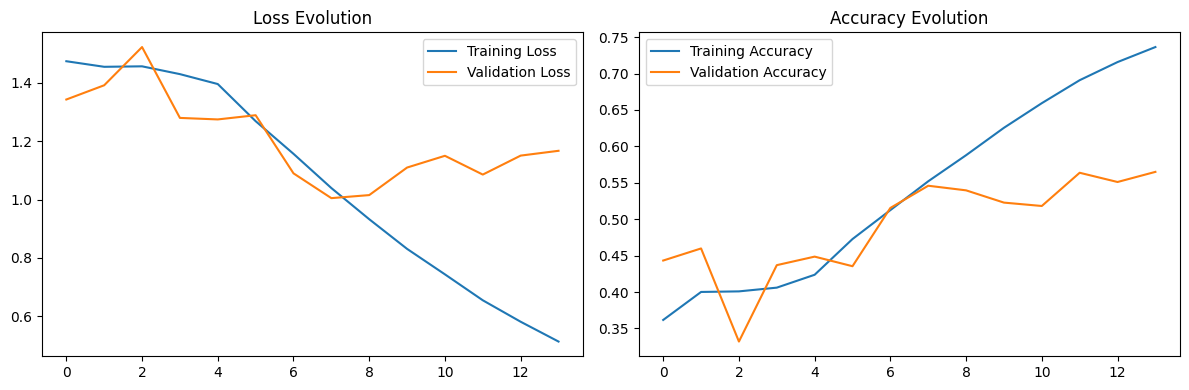

In [84]:
plot_loss_accuracy(weighted_baseline_history)

### ***Observation:***

# ***need to recalculate with the seed***
- The F1 score for class 0 improved by approximately 30%.
- The F1 score for class 1 improved by approximately 13%.
- The F1 score for class 2 improved by approximately 7%.
- The F1 score for class 3 decreased by approximately 9%.
- The F1 score for class 4 decreased by approximately 8%.
- accuracy decresead by around 7%

These results are super interesting as we got what we wanted: better result for class with a small amount of datas and not just a model that predict almost always a rating of 4 or 5 (class 3 and 4) what garaties a good accuracy as it is the most common data.

However, the model start to overfit a bit from around epoch 8 even if the curves is still improving so we may consider to learn the model more.

We will try some adjustement to see the impact on overfitting.

# ***Reduce complexity of the model to reduce overfitting***

modifying the first LSTM Layers from 64 to 32 units and the second LSTM Layers from 32 to 16 units.



In [ ]:
checkpoint = ModelCheckpoint('simpler_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

simpler_model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(5, activation='softmax')
])

simpler_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
simpler_model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
simpler_history = simpler_model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=15, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

simpler_best_model = load_model('simpler_model.h5')



In [86]:
evaluate_model(simpler_best_model, val_sequences, val_labels)


129/129 [==============================] - 5s 30ms/step - loss: 1.0908 - accuracy: 0.5599
Validation Loss: 1.0908458232879639
Validation Accuracy: 0.5598926544189453
129/129 [==============================] - 4s 25ms/step
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       292
           1       0.32      0.36      0.34       333
           2       0.28      0.35      0.31       432
           3       0.49      0.33      0.40      1252
           4       0.70      0.81      0.75      1790

    accuracy                           0.56      4099
   macro avg       0.48      0.48      0.47      4099
weighted avg       0.55      0.56      0.55      4099



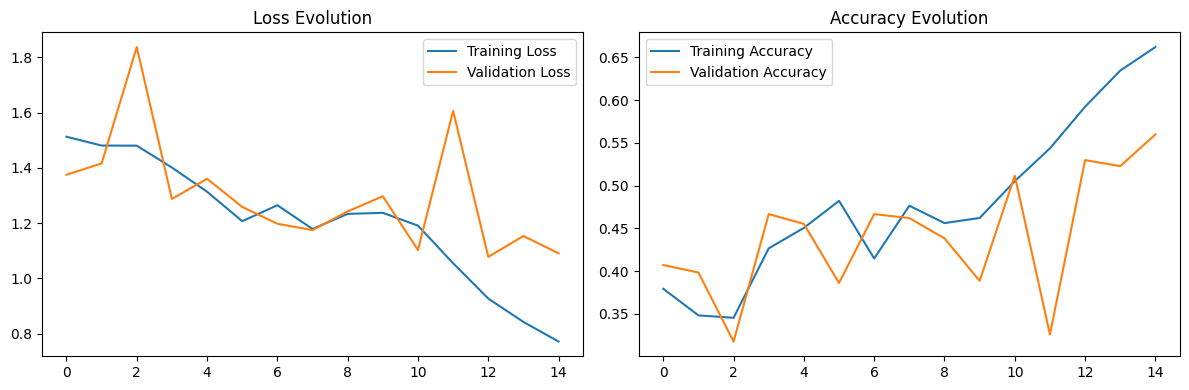

In [87]:
plot_loss_accuracy(simpler_history)

### ***Observation:***

- It seems that we reduced Overfitting, the curves are more aligned and the gap between training and validation is smaller.
- The model lost a bit of quality in accuracy and f1 score for almost each classes apart class 4
- the learning curves shows erratic behavior with frequent fluctuation.

I'm interested to train it more as despite the erratic behavior the validation has a positive trend but it takes a lot of time so I'm considering to change the batch size

# ***changing batch size to accelerate training***

We will try to increase the batch size to accelerate the training process and try to get better result by training more this simpler model. However changing batch size may have an impact.
If the quality of the model is not improving we will not go further with this simpler model as I'm not confident to work with a model so fluctuant

In [ ]:
checkpoint = ModelCheckpoint('batch_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

batch_increase_model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(5, activation='softmax')
])

batch_increase_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
batch_increase_model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
batch_history = batch_increase_model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=25, batch_size=64, class_weight=class_weights_dict, callbacks=[checkpoint, lr_cb])

batch_best_model = load_model('batch_model.h5')


In [93]:
evaluate_model(batch_best_model, val_sequences, val_labels)

129/129 [==============================] - 7s 41ms/step - loss: 1.2385 - accuracy: 0.5775
Validation Loss: 1.2384679317474365
Validation Accuracy: 0.5774579048156738
129/129 [==============================] - 8s 46ms/step
              precision    recall  f1-score   support

           0       0.68      0.48      0.56       292
           1       0.36      0.41      0.38       333
           2       0.32      0.31      0.31       432
           3       0.49      0.57      0.53      1252
           4       0.75      0.70      0.72      1790

    accuracy                           0.58      4099
   macro avg       0.52      0.49      0.50      4099
weighted avg       0.59      0.58      0.58      4099



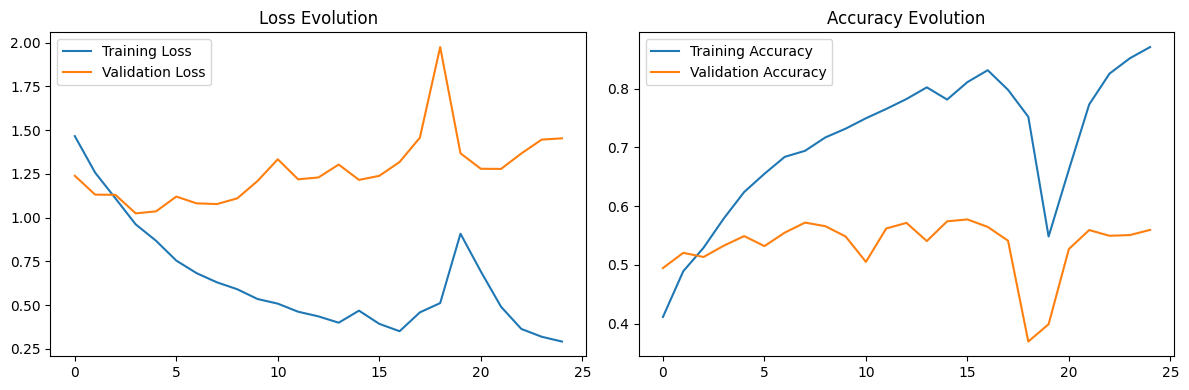

In [94]:
plot_loss_accuracy(batch_history)

- Validation curve is not improving
- huge overfitting
- F1 scores are better

this simpler model does not show interestin results. We will not go further and continue on our previous architecture.

## Exploring Different Optimizers

- **Nadam:** Combines RMSprop's adaptive learning rate with Nesterov momentum, offering faster convergence for complex datasets and deep networks.
- **SGD** (Stochastic Gradient Descent): Provides a simpler, more traditional approach that can lead to better generalization, especially beneficial for less complex models.
- **RMSprop:** Adjusts the learning rate dynamically to handle non-stationary objectives and gradients, making it suitable for a wide range of neural networks.

In [ ]:
checkpoint = ModelCheckpoint('NAdam_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
NAdam_history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=15, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

NAdam_best_model = load_model('NAdam_model.h5')


In [96]:
evaluate_model(NAdam_best_model, val_sequences, val_labels)

129/129 [==============================] - 5s 32ms/step - loss: 1.1902 - accuracy: 0.5801
Validation Loss: 1.1902331113815308
Validation Accuracy: 0.5801414847373962
129/129 [==============================] - 6s 36ms/step
              precision    recall  f1-score   support

           0       0.75      0.38      0.51       292
           1       0.34      0.41      0.37       333
           2       0.31      0.41      0.35       432
           3       0.53      0.42      0.47      1252
           4       0.72      0.79      0.76      1790

    accuracy                           0.58      4099
   macro avg       0.53      0.48      0.49      4099
weighted avg       0.59      0.58      0.58      4099



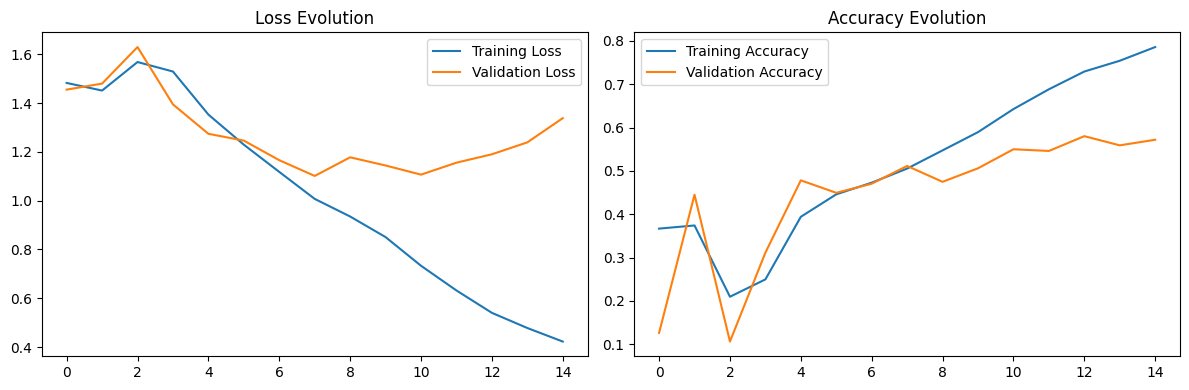

In [97]:
plot_loss_accuracy(NAdam_history)

### ***Observation:***

Globally this optimizer shows good results with an accuracy of 0.58 similar to Adam(), validation Accuracy is on a positive trend. We notice 9% F1 improvement on class 2 and 3 but 16% less in class 1

In [ ]:
checkpoint = ModelCheckpoint('SGD_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
SGD_history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=15, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

SGD_best_model = load_model('SGD_model.h5')


In [99]:
evaluate_model(SGD_best_model, val_sequences, val_labels)


129/129 [==============================] - 5s 31ms/step - loss: 1.5873 - accuracy: 0.3496
Validation Loss: 1.5873053073883057
Validation Accuracy: 0.3495974540710449
129/129 [==============================] - 6s 40ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.10      0.38      0.16       333
           2       0.00      0.00      0.00       432
           3       0.29      0.06      0.10      1252
           4       0.47      0.69      0.56      1790

    accuracy                           0.35      4099
   macro avg       0.17      0.23      0.16      4099
weighted avg       0.30      0.35      0.29      4099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


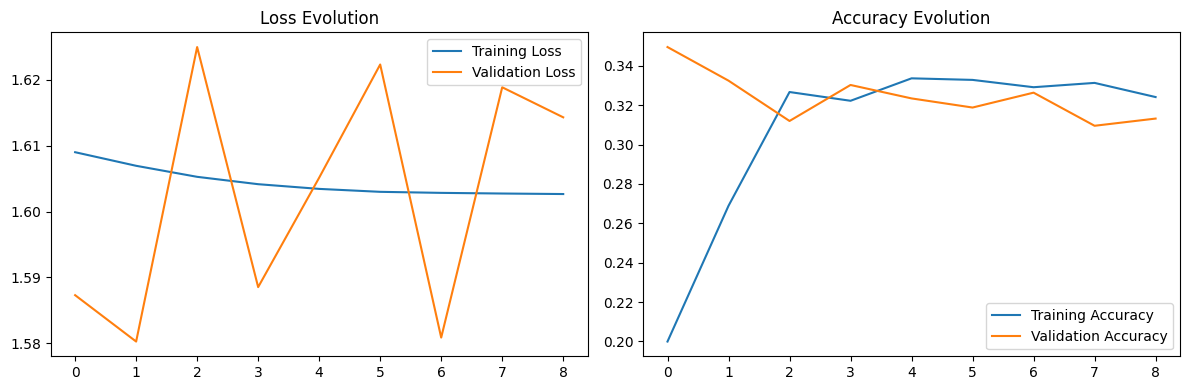

In [100]:
plot_loss_accuracy(SGD_history)

### ***Observation:***

Result with SGD are not good at all, SGD with our LSTM model does not fit. It does not mean that SGD is not able to solve this probleme but it seems like we should change our architecture, the algorithm that we are using or hyperparameter so we will just eliminate it from our research

In [ ]:
checkpoint = ModelCheckpoint('RMS_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
RMS_history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=15, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

RMS_best_model = load_model('RMS_model.h5')


In [102]:
evaluate_model(RMS_best_model, val_sequences, val_labels)

129/129 [==============================] - 7s 43ms/step - loss: 1.0494 - accuracy: 0.5958
Validation Loss: 1.0494447946548462
Validation Accuracy: 0.5957550406455994
129/129 [==============================] - 6s 35ms/step
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       292
           1       0.36      0.46      0.41       333
           2       0.39      0.41      0.40       432
           3       0.52      0.56      0.53      1252
           4       0.77      0.70      0.73      1790

    accuracy                           0.60      4099
   macro avg       0.54      0.54      0.54      4099
weighted avg       0.61      0.60      0.60      4099



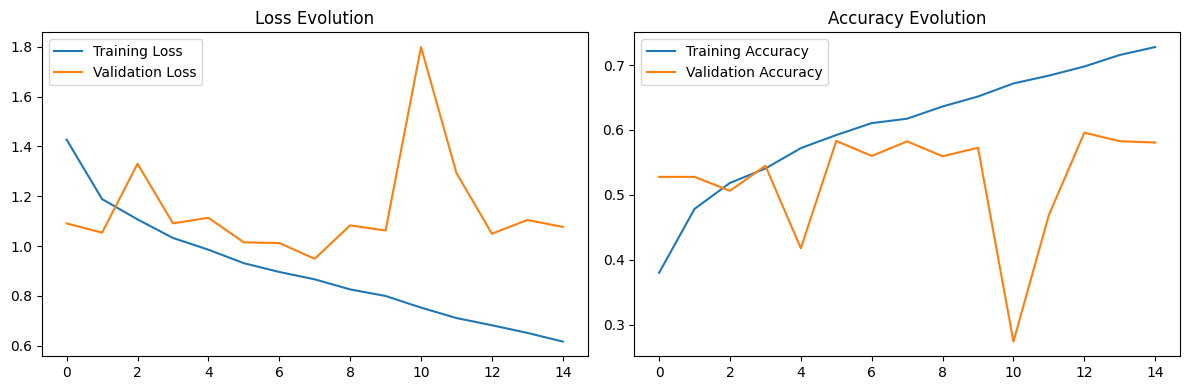

In [103]:
plot_loss_accuracy(RMS_history)

### ***Observation:***

These result are really interesting.
Curves, despite a strange point a epoch 10 are quite good comparated to what we are able to obtain from the beginning.
Not perfect at all, still overfitting but quite goo comparated to others.

- The F1 score for class 0 is similar.
- The F1 score for class 1 improved by approximately 21%.
- The F1 score for class 2 improved by approximately 25%.
- The F1 score for class 3 improved by approximately 4%.
- The F1 score for class 4 improved by approximately 1%.
- accuracy improved by around 5%

We clearly found something that improved our model

# ***Others model architecture***

We will now test others neural network architecture which may be better for this task.

## **Convolutional Neural Network (CNN)**

### Model Explanation

CNN architecture distinct from the LSTM-based first model, provide a different approach to processing sequential data. CNNs have proven effectiveness in natural language processing tasks due to their ability to detect patterns (like word sequences) within the data.
- The Conv1D layer in this model captures local dependencies and patterns in the text, offering potentially faster training times and requiring fewer computational resources compared to LSTM.
- The GlobalMaxPooling1D layer following it reduces the dimensionality, summarizing the most significant features learned by the convolutional layer.



In [ ]:
checkpoint = ModelCheckpoint('CNN_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
CNN_history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=32,class_weight=class_weights_dict, callbacks=[checkpoint, lr_cb])

CNN_best_model = load_model('CNN_model.h5')



In [124]:
evaluate_model(CNN_best_model, val_sequences, val_labels)

129/129 [==============================] - 1s 8ms/step - loss: 0.9999 - accuracy: 0.5904
Validation Loss: 0.9999181628227234
Validation Accuracy: 0.5903878808021545
129/129 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       292
           1       0.33      0.46      0.38       333
           2       0.36      0.38      0.37       432
           3       0.53      0.52      0.53      1252
           4       0.79      0.70      0.74      1790

    accuracy                           0.59      4099
   macro avg       0.51      0.55      0.53      4099
weighted avg       0.61      0.59      0.60      4099



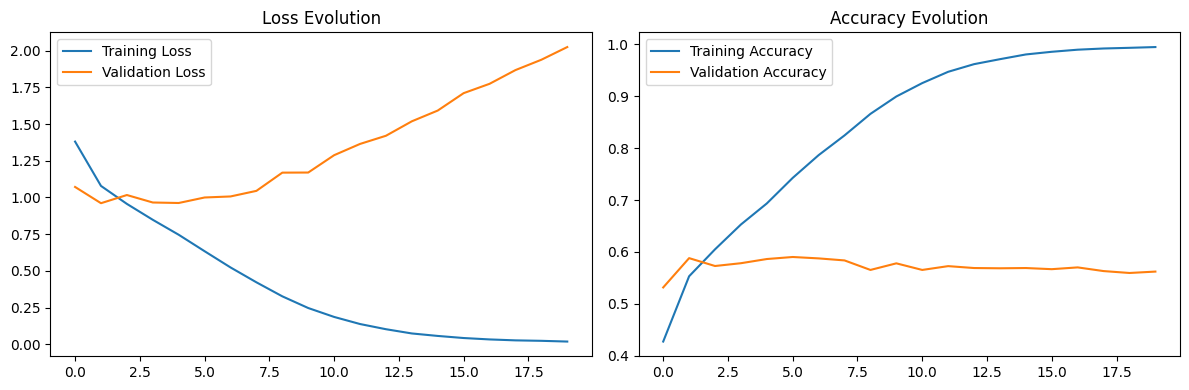

In [125]:
plot_loss_accuracy(CNN_history)

### ***Observation:***

- The accuracy and f1 score are good but less than with our LSTM model.
- learning curve are divergent, typical of overfitting

# ***Bidirectional LSTM***

### Model Explanation

The Bi-LSTM layer in this model is capable of gathering contextual information from both past and future data points in the sequence. This feature is particularly advantageous for understanding the full context of a word in a sentence, leading to more accurate predictions.
The inclusion of L2 regularization (kernel_regularizer and recurrent_regularizer) in the Bi-LSTM layer helps in preventing overfitting by penalizing the weights during training. This is particularly useful for complex models with a large number of parameters.

The increased dropout rate (0.5) further aids in reducing overfitting by randomly dropping units (along with their connections) during the training process. This encourages the model to learn robust features that are useful across various representations of the input data.
Regularized Dense Layer:

The final Dense layer with softmax activation is used for classification. It also includes L2 regularization (kernel_regularizer and activity_regularizer), which helps in mitigating overfitting by penalizing large weights and the output of the neurons, respectively.


In [ ]:
from keras.regularizers import l2

checkpoint = ModelCheckpoint('BiLSTM23_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)


model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64)),  # Bi-LSTM
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
BiLSTM_23_history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=11, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb]);

BiLSTM_best23_model = load_model('BiLSTM23_model.h5')

In [118]:
evaluate_model(BiLSTM_best23_model, val_sequences, val_labels)

129/129 [==============================] - 5s 30ms/step - loss: 0.8429 - accuracy: 0.6343
Validation Loss: 0.8429068922996521
Validation Accuracy: 0.6343010663986206
129/129 [==============================] - 5s 31ms/step
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       292
           1       0.43      0.51      0.47       333
           2       0.44      0.32      0.37       432
           3       0.61      0.41      0.49      1252
           4       0.70      0.89      0.78      1790

    accuracy                           0.63      4099
   macro avg       0.58      0.55      0.55      4099
weighted avg       0.62      0.63      0.62      4099



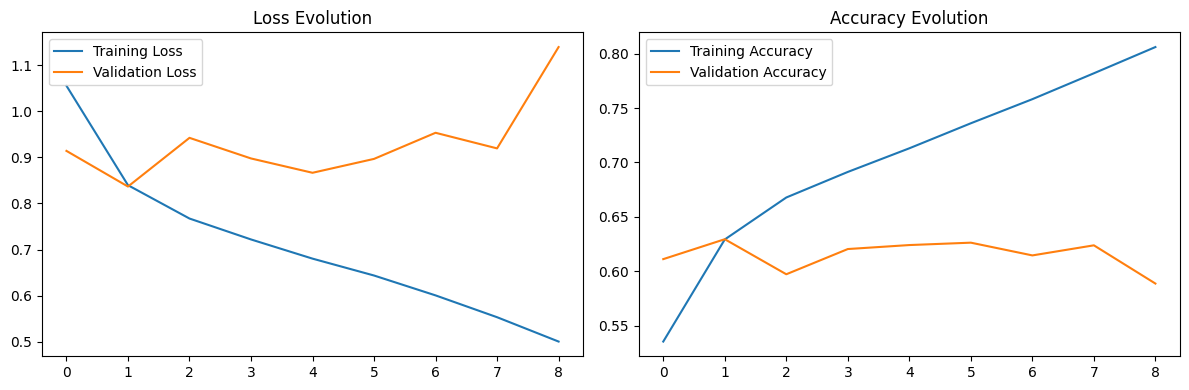

In [13]:
plot_loss_accuracy(BiLSTM_23_history)

Comparated to Previous LSTM

- The F1 score for class 0 improved by approximately +8%.
- The F1 score for class 1 improved by approximately +15%.
- The F1 score for class 2 decreased by approximately -8%.
- The F1 score for class 3 decreased by approximately -8%.
- The F1 score for class 4 improved by approximately +7%.
- accuracy improved by around +2%

Learning curves still exhibit overfitting but it's the best model so far, it get the best accuracy from all our model while obtaining a good recall on class 1 2 and 3 leading to good f1 score for each class.

129/129 [==============================] - 5s 42ms/step


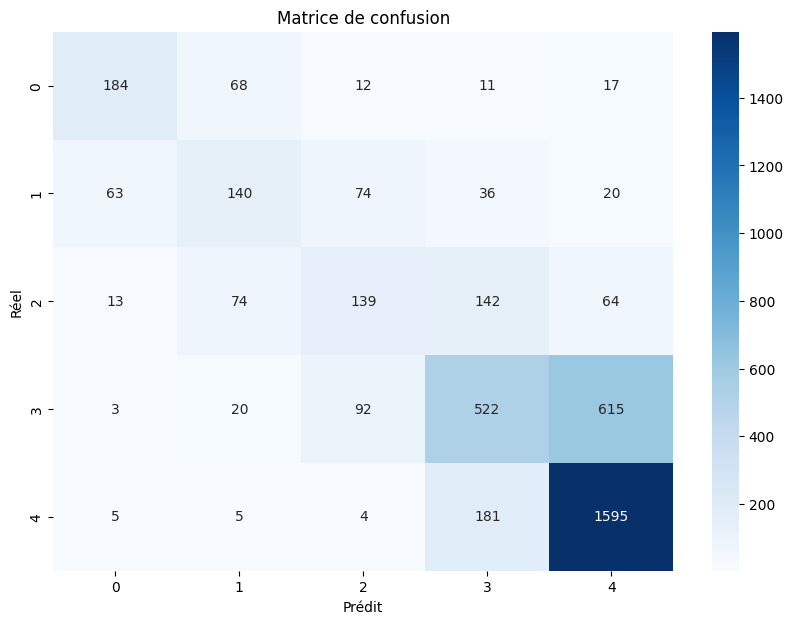

In [18]:
plot_confusion_matrix(BiLSTM_best23_model, val_sequences, val_labels)

By analizing the Confusion Matrix we observe that our model does approximately the same errors than the ML model: it is doing mistakes between close classe but does not make big mistake or a really small amount

Logistic Regression with balanced class weights

              precision    recall  f1-score   support

           1       0.65      0.70      0.67       292
           2       0.38      0.48      0.43       333
           3       0.36      0.44      0.39       432
           4       0.55      0.48      0.52      1252
           5       0.77      0.75      0.76      1790
          accuracy                     0.61      4099

We observe that this Deep Learning is even able to get better result than the ML model

- The F1 score for class 0 decreased by approximately -1%.
- The F1 score for class 1 improved by approximately +19%.
- The F1 score for class 2 decreased by approximately -5%.
- The F1 score for class 3 decreased by approximately -6%.
- The F1 score for class 4 improved by approximately +3%.
- accuracy improved by around +3%

a big improvement on class 2, similar result on others class and interesting improvement of the accuracy.

# ***Re mapping the dataset***

Following the same idea than ML models

In [10]:
dataset = pd.read_csv('/content/cleaned_tripadvisor_reviews.csv', index_col=0)
mapping = {1: 0, 2: 0, 3: 0, 4: 1, 5: 2}
dataset['sentiment'] = dataset['Rating'].map(mapping)
labels = dataset['sentiment'].values

In [ ]:
checkpoint = ModelCheckpoint('remap2_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64)),  # Bi-LSTM
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])
model.summary()

train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
RMS_remap_history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=12, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb]);

RMS_best_remap_model = load_model('remap2_model.h5')



In [18]:
evaluate_model(RMS_best_remap_model, val_sequences, val_labels)

129/129 [==============================] - 5s 32ms/step - loss: 0.6522 - accuracy: 0.7212
Validation Loss: 0.6521724462509155
Validation Accuracy: 0.7211514711380005
129/129 [==============================] - 5s 27ms/step
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1057
           1       0.60      0.49      0.54      1252
           2       0.73      0.84      0.78      1790

    accuracy                           0.72      4099
   macro avg       0.72      0.71      0.71      4099
weighted avg       0.71      0.72      0.71      4099



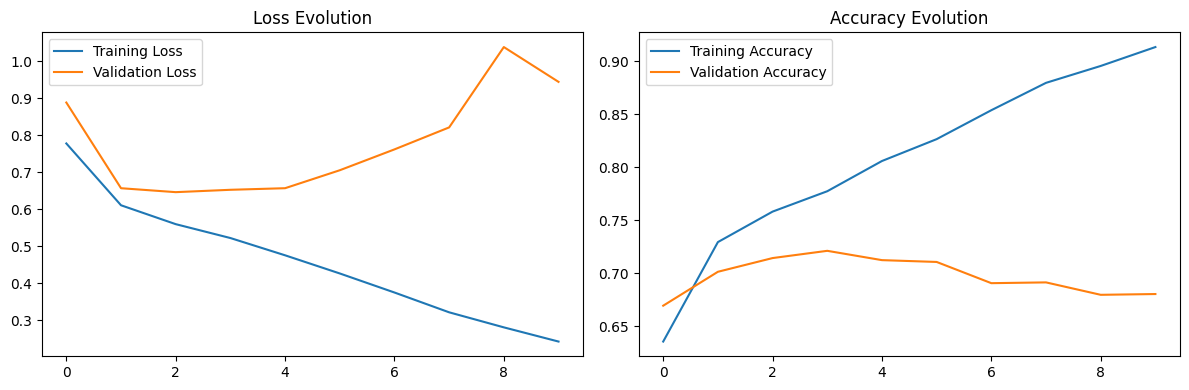

In [19]:
plot_loss_accuracy(RMS_remap_history)

129/129 [==============================] - 3s 25ms/step


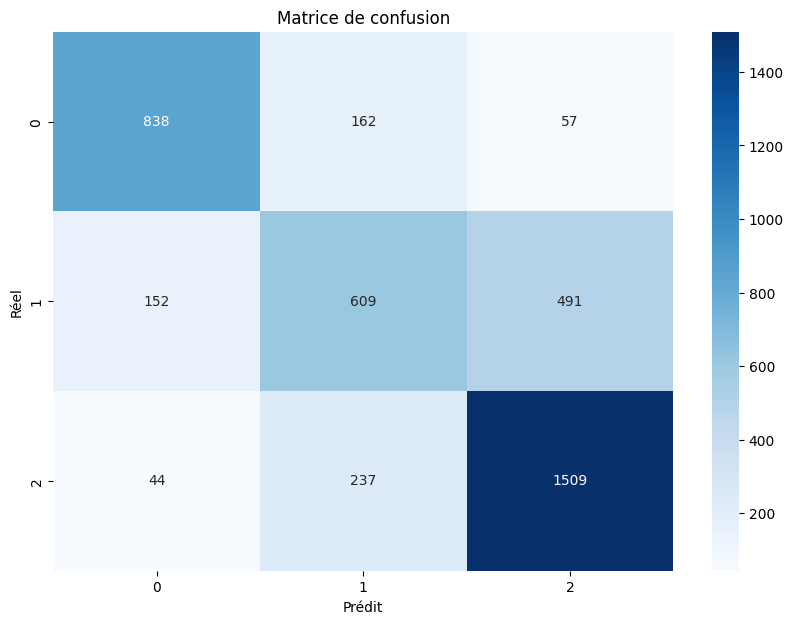

In [20]:
plot_confusion_matrix(RMS_best_remap_model, val_sequences, val_labels)

### ***Observation:***

Finally we notice results really similar to ML, f1 score and accuracy are rally similar, confusion matrix too. we get approximately the same problems on class "good" we have excelent result on "negative" and "excellent"

This remapping is a good way too improve our model while keeping sense in terms of business for an hotel

# ***Analysis of the results***

As we used Softmax, it is easy to analyze the probabilities of our results so I want to know the probablities of Class Good False negative in order to search for some explanation, improvement.

In [42]:
import pandas as pd
import numpy as np

# Prédire les probabilités pour l'ensemble de validation
predicted_probabilities = RMS_best_remap_model.predict(val_sequences)

# Obtenir les classes prédites
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Assurez-vous que vous avez les bonnes étiquettes ici (val_labels au lieu de train_labels)
# Identifier les cas mal classifiés où la vraie classe est 1
misclassified = np.where((val_labels == 1) & (predicted_classes != 1))

# Créer un DataFrame pour afficher les résultats
misclassified_data = pd.DataFrame(predicted_probabilities[misclassified],
                                  columns=['Prob_Class_0', 'Prob_Class_1', 'Prob_Class_2'])
misclassified_data['True_Label'] = val_labels[misclassified]
misclassified_data['Predicted_Label'] = predicted_classes[misclassified]

misclassified_data.describe()


129/129 [==============================] - 8s 60ms/step


,Prob_Class_0,Prob_Class_1,Prob_Class_2,True_Label,Predicted_Label
count,692.000000,692.000000,692.000000,692.0,692.000000
mean,0.233062,0.257821,0.509117,1.0,1.421965
std,0.345300,0.137422,0.319252,0.0,0.907268
min,0.000310,0.001642,0.000122,1.0,0.000000
25%,0.006488,0.144604,0.115523,1.0,0.000000
50%,0.018145,0.260992,0.598215,1.0,2.000000
75%,0.511592,0.375431,0.767816,1.0,2.000000
max,0.998236,0.495889,0.988036,1.0,2.000000


<Axes: >

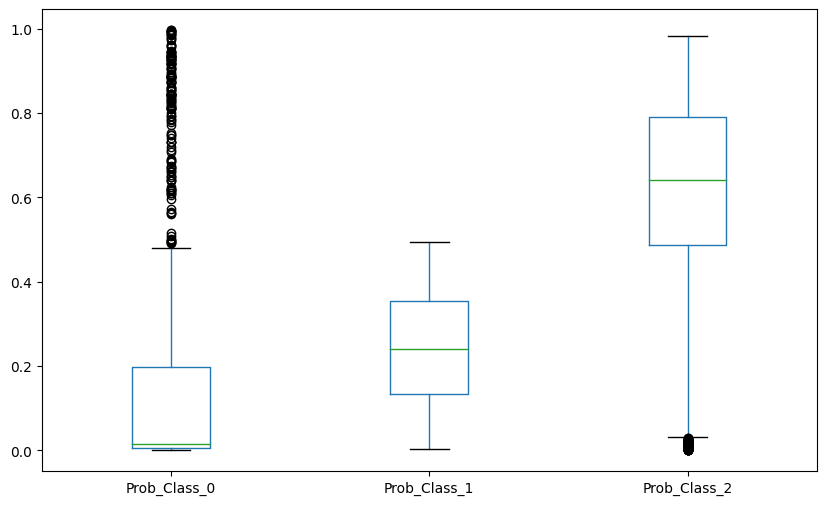

In [25]:
misclassified_data.boxplot(column=['Prob_Class_0', 'Prob_Class_1', 'Prob_Class_2'], grid=False, figsize=(10, 6))


### ***Observation:***

- 50% of class 1 false negative have a probability above 0.25 to be class 1
- Most of them have a probability above 0.5 to be class 2

We may consider to class each review with a probabililty above 0.25 to be class 1 as class 1 but before we need to ensure that we will not create too much false positive ie. not classify True class 0 as Class 1 if we have P(0) = 0.7 and P(1) = 0.25 what will lead to a wrong classification

129/129 [==============================] - 6s 47ms/step


<Axes: >

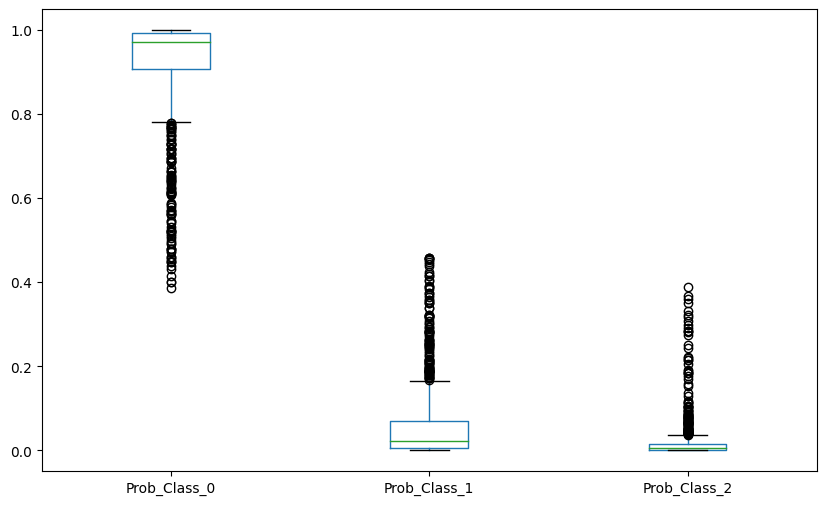

In [28]:
import pandas as pd
import numpy as np

# Prédire les probabilités pour l'ensemble de validation
predicted_probabilities = RMS_best_remap_model.predict(val_sequences)

# Obtenir les classes prédites
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Assurez-vous que vous avez les bonnes étiquettes ici (val_labels au lieu de train_labels)
# Identifier les cas mal classifiés où la vraie classe est 1
misclassified = np.where((val_labels == 0) & (predicted_classes == 0))

# Créer un DataFrame pour afficher les résultats
misclassified_data = pd.DataFrame(predicted_probabilities[misclassified],
                                  columns=['Prob_Class_0', 'Prob_Class_1', 'Prob_Class_2'])
misclassified_data['True_Label'] = val_labels[misclassified]
misclassified_data['Predicted_Label'] = predicted_classes[misclassified]

misclassified_data.boxplot(column=['Prob_Class_0', 'Prob_Class_1', 'Prob_Class_2'], grid=False, figsize=(10, 6))

### ***Observation:***

There is only a really small amount (some outliers) of class 0 with a probability above 0.25 to be class 1 so it should not create any problems apart a really small amount of misclassification

129/129 [==============================] - 6s 47ms/step


<Axes: >

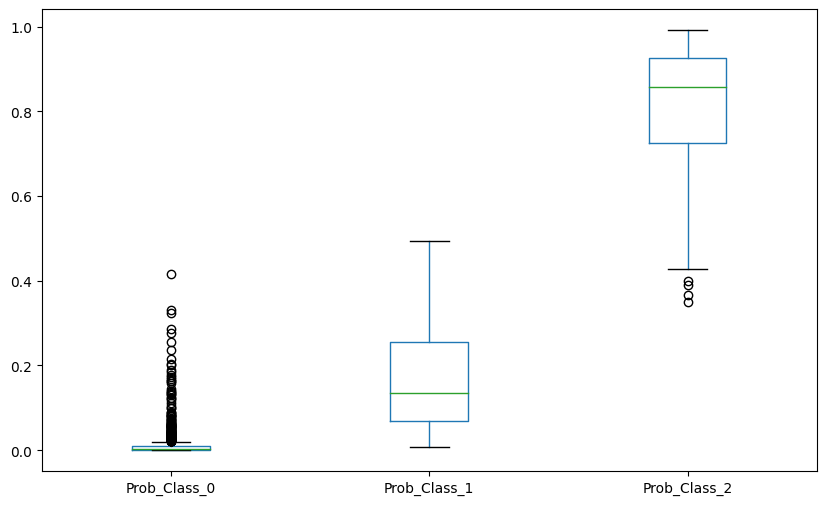

In [30]:
import pandas as pd
import numpy as np

# Prédire les probabilités pour l'ensemble de validation
predicted_probabilities = RMS_best_remap_model.predict(val_sequences)

# Obtenir les classes prédites
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Assurez-vous que vous avez les bonnes étiquettes ici (val_labels au lieu de train_labels)
# Identifier les cas mal classifiés où la vraie classe est 1
misclassified = np.where((val_labels == 2) & (predicted_classes == 2))

# Créer un DataFrame pour afficher les résultats
misclassified_data = pd.DataFrame(predicted_probabilities[misclassified],
                                  columns=['Prob_Class_0', 'Prob_Class_1', 'Prob_Class_2'])
misclassified_data['True_Label'] = val_labels[misclassified]
misclassified_data['Predicted_Label'] = predicted_classes[misclassified]

misclassified_data.boxplot(column=['Prob_Class_0', 'Prob_Class_1', 'Prob_Class_2'], grid=False, figsize=(10, 6))

# ***Observation:***

We notice that in this case, the number of True Class 2 that have a probability to be class 1 above 0.25 is not negligible so we may consider to not use this threshold to classify class 1 just has we said or it will lead to a lot of errors by classifying class 1 a lot of reviews that our model classified correctly as class 2

to Reduce this problem we may consider to add another threshold: 
if P(2) < 0.6 and P(1) > 0.25 then class 1 else most probable class

We choose 0.6 as we notice that True Class 2 often have an high probability to be class 2 a big part of them have a probability above 0.6 to be class 2 so it is a good filter. if the probability is high. we keep it as it is but if the probabilty os low we may consider to classify it as class 1 if the probability to be class 1 is above 0.25 as we saw on first plot

In [38]:
def custom_class_assignment(predicted_probabilities, threshold=0.25, max_prob_threshold=0.6):
    """
    Assign classes based on custom logic:
    - Choose the class with the highest probability unless the probability of class 1 is greater than `threshold`
      and the highest probability is less than `max_prob_threshold`.
    - In that case, choose class 1.
    """
    custom_classes = []
    for probs in predicted_probabilities:
        max_prob = np.max(probs)
        if probs[1] > threshold and max_prob < max_prob_threshold:
            custom_classes.append(1)
        else:
            custom_classes.append(np.argmax(probs))
    return np.array(custom_classes)

# Utiliser la fonction sur vos probabilités prédites
custom_predicted_classes = custom_class_assignment(predicted_probabilities)


In [39]:
print(classification_report(val_labels, custom_predicted_classes, target_names=['Class 0', 'Class 1', 'Class 2']))

              precision    recall  f1-score   support

     Class 0       0.82      0.78      0.80      1057
     Class 1       0.56      0.61      0.58      1252
     Class 2       0.78      0.76      0.77      1790

    accuracy                           0.72      4099
   macro avg       0.72      0.71      0.72      4099
weighted avg       0.72      0.72      0.72      4099



### ***Observation:***

This set of rules improved ou model by increasing f1 score of class 1 by 0.04 with an huge impact on recall of this class (+0.12)
while having a small impact on F1 of class 2 (only -0.01) and keeping the same accuracy. Really interesting results